<a href="https://colab.research.google.com/github/kiberbull/AZSII/blob/main/prz4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/ASZI')
os.getcwd()


'/content/drive/MyDrive/Colab Notebooks/ASZI'

In [3]:

!pip install art
!pip install adversarial-robustness-toolbox

In [4]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Загрузка данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0

# Преобразование меток в формат one-hot encoding
test_labels = to_categorical(test_labels, num_classes=10)

# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')

# Компиляция модели
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Проверка точности модели на тестовых данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy on clean images: {test_acc}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1056 - loss: 2.3705
Test accuracy on clean images: 0.11259999871253967


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


tf.Tensor(7, shape=(), dtype=int64)


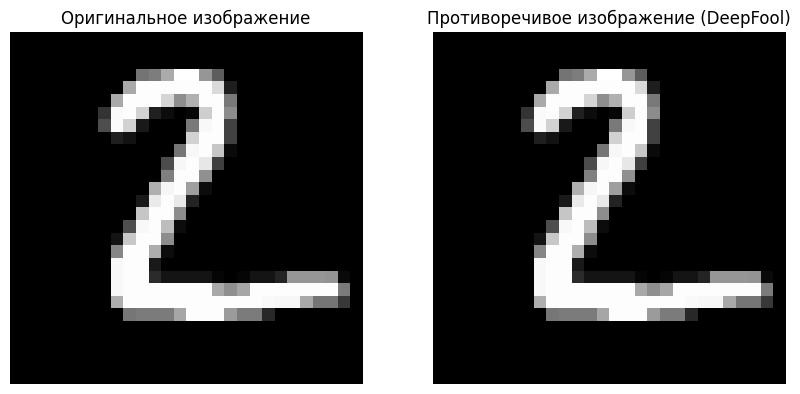

In [5]:
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(-1, 1))

image = tf.convert_to_tensor(test_images[1], dtype=tf.float32)[None, ...]  # Добавляем размерность для батча
label = np.argmax(test_labels[0])  # Получаем индекс класса
label = tf.convert_to_tensor(label, dtype=tf.int64)  # Преобразуем в тензор

# Выполнение атаки
attack = fb.attacks.L2DeepFoolAttack(steps=10)
print(label)
advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)  # Оборачиваем метку в тензор с размерностью (1,)

# Вывод результатов
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (DeepFool)")
plt.imshow(advs[0].numpy(), cmap="gray")  # Предполагается, что advs имеет правильную форму
plt.axis('off')

plt.show()

In [6]:
import tensorflow as tf
import numpy as np

# Количество случайных изображений
num_random_images = 100

# Выбираем случайные индексы из тестового набора
random_indices = np.random.choice(len(test_images), num_random_images, replace=False)

adversarial_images = []

# Обрабатываем только 100 случайных изображений
for i in random_indices:
    # Преобразуем изображение в тензор с правильным типом
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]

    # Предполагаем, что метки уже в one-hot формате, если нет, используем np.argmax
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)  # Преобразуем метку в тензор

    # Генерация атакованного изображения с использованием метода __call__
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)
    adversarial_images.append(advs)

# Объединяем все атакованные изображения
adversarial_images = tf.concat(adversarial_images, axis=0)

# Оценка модели на атакованных изображениях
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels[random_indices])
print(f'Accuracy on adversarial examples (DeepFool) для 100 рандомных изображений: {adversarial_acc}')


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 399ms/step - accuracy: 0.0000e+00 - loss: 2.4060
Accuracy on adversarial examples (DeepFool) для 100 рандомных изображений: 0.0


DeepFool:   0%|          | 0/100 [00:00<?, ?it/s]

Точность на исходных изображениях: 4.00%
Точность на атакованных изображениях: 9.00%
Потери на исходных изображениях: 2.4554
Потери на атакованных изображениях: 2.4456


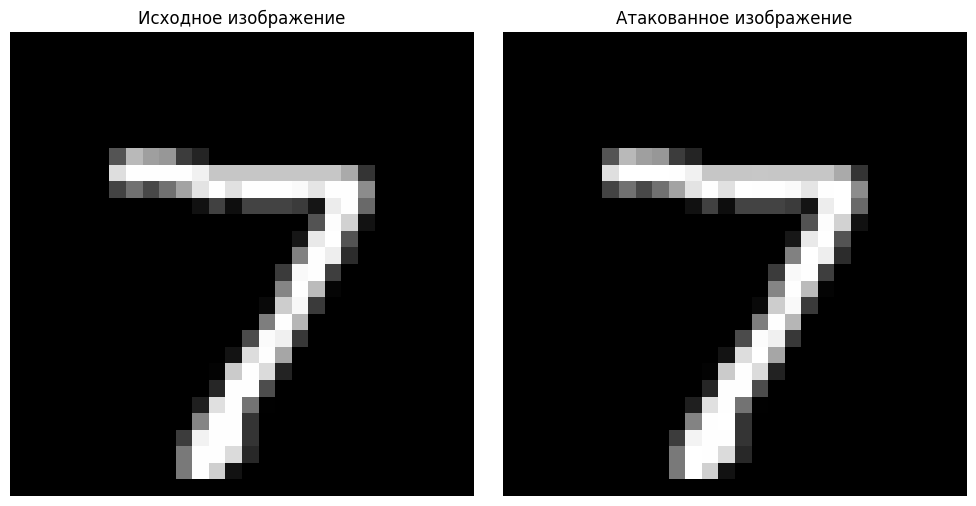

In [9]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from art.attacks.evasion import DeepFool
from art.estimators.classification import TensorFlowV2Classifier
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score

# 1. Загрузка модели
model = load_model('mnist_model.h5', compile=False)  # Загружаем модель без компиляции

# Компиляция модели вручную для функций потерь и метрик
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 2. Загрузка и подготовка данных MNIST
(_, _), (x_test, y_test) = mnist.load_data()
x_test = x_test.astype(np.float32) / 255.0  # Нормализация
x_test = np.expand_dims(x_test, axis=-1)  # Добавление канала

# Используем подмножество данных
x_test_subset = x_test[:100]
y_test_subset = y_test[:100]
y_test_one_hot = to_categorical(y_test_subset, 10)  # One-hot encoding

# 3. Создание классификатора для ART
classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=10,
    input_shape=(28, 28, 1),
    clip_values=(0, 1)
)

# 4. Применение атаки DeepFool
attack = DeepFool(classifier, max_iter=20)  # Уменьшено количество итераций
adv_images = attack.generate(x=x_test_subset)

# 5. Предсказания модели
original_predictions = np.argmax(model.predict(x_test_subset, verbose=0), axis=1)
adv_predictions = np.argmax(model.predict(adv_images, verbose=0), axis=1)

# 6. Вычисление точности
original_accuracy = accuracy_score(y_test_subset, original_predictions)
adv_accuracy = accuracy_score(y_test_subset, adv_predictions)

# 7. Оценка потерь
original_loss = model.evaluate(x_test_subset, y_test_one_hot, verbose=0)[0]
adv_loss = model.evaluate(adv_images, y_test_one_hot, verbose=0)[0]

# 8. Вывод результатов
print(f"Точность на исходных изображениях: {original_accuracy * 100:.2f}%")
print(f"Точность на атакованных изображениях: {adv_accuracy * 100:.2f}%")
print(f"Потери на исходных изображениях: {original_loss:.4f}")
print(f"Потери на атакованных изображениях: {adv_loss:.4f}")

# 9. Визуализация примеров
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(x_test_subset[0].reshape(28, 28), cmap='gray')
plt.title("Исходное изображение")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(adv_images[0].reshape(28, 28), cmap='gray')
plt.title("Атакованное изображение")
plt.axis('off')

plt.tight_layout()
plt.show()
